In [2]:
import numpy as np
from matplotlib import pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
#define constants
n = 64
s = 1
sigma2 = 1

#load data
train = np.loadtxt('hw6_q2_train.csv', delimiter=",", dtype=float)
test = np.loadtxt('hw6_q2_test.csv', delimiter=",", dtype=float)

In [17]:
#function that computes kernel
def kernel(x,xp,s):
    k = np.e**(-(1 / (2 * s**2)) * np.linalg.norm(x - xp))
    return k

#define a function to "fill" a matrix with kernel values to make life easier, only works for vector size of 1
def mkernel(x,xp,s):
    dimx = np.size(x)
    dimxp = np.size(xp)
                    
    k = np.zeros((dimx, dimxp))
    
    for i in range(dimx):
        for j in range(dimxp):
            k[i,j] = kernel(x[i],xp[j],s)
    return k

#function that computes kernels for GPR
def gpr(x_train, x_test, y_train, s, sigma_2):
    mean = mkernel(x_train, x_test, s).T @ np.linalg.inv(mkernel(x_train,x_train,s) 
                                                         + sigma_2 * np.eye(len(x_train))) @ (y_train - 0)
    covariance = mkernel(x_test, x_test, s) - mkernel(x_train, x_test, s).T @ np.linalg.inv(mkernel(x_train, x_train, s) 
                                                                                            + sigma_2 * np.eye(len(x_train))) @ mkernel(x_train, x_test, s)
    return mean, covariance

In [5]:
#split training data into x and y 
x_train = train[:,0]
y_train = train[:,1]

#compute predictions
x_values = np.linspace(-5,5,100)
mean, covariance = gpr(x_train, x_values, y_train, s, sigma2)


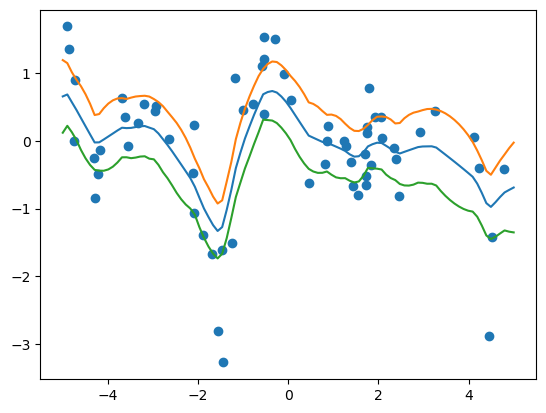

In [18]:
plt.scatter(x_train, y_train) 
plt.plot(x_values, mean)
plt.plot(x_values, mean + np.sqrt(np.diag(covariance)))
plt.plot(x_values, mean - np.sqrt(np.diag(covariance)))

In [25]:
burger1=np.append(x_train, x_train,0)
burger2=np.append(y_train, y_train + np.ones(n),0)
bmean, bcov = gpr(burger1, x_values, burger2, s, sigma2)

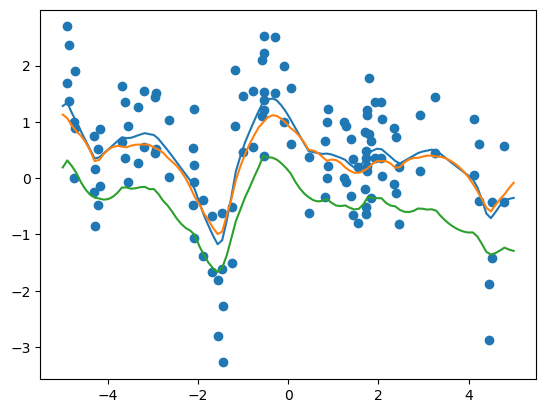

In [27]:
plt.scatter(burger1, burger2) 

plt.plot(x_values, bmean)
plt.plot(x_values, mean + np.sqrt(np.diag(bcov)))
plt.plot(x_values, mean - np.sqrt(np.diag(bcov)))

In [21]:
np.append(y_train, y_train + np.ones(n),0)

array([ 2.23495837e-01, -1.61352769e+00, -1.06320023e+00, -1.67573228e+00,
       -2.48327095e-01, -4.21045117e-01, -6.91904311e-02,  3.96589785e-01,
       -4.82257326e-01,  9.28346575e-01, -2.80253722e+00, -2.87796745e+00,
        6.00906045e-01,  5.11599366e-01,  1.36566165e+00, -7.29062370e-02,
        6.33311888e-01, -6.43144354e-01, -8.09181756e-01, -3.27508606e+00,
        5.52520493e-01,  5.51137463e-01, -2.61738316e-04,  7.80277256e-01,
       -2.65216024e-01,  1.21619473e+00,  4.38325568e-02,  1.53357636e+00,
       -5.18504674e-01, -3.10397027e-01, -7.96500271e-01,  3.50814599e-01,
        3.81315993e-04,  8.97934937e-01, -3.27060940e-03, -3.36533223e-01,
        3.54514610e-01, -6.16657254e-01, -8.42361593e-01,  9.98186855e-01,
        5.64116464e-02, -6.61847817e-01,  2.10330935e-01,  1.51374366e+00,
       -1.88640304e-01, -1.50654641e+00,  2.47617687e-02,  4.37461654e-01,
       -1.38563297e+00, -1.08757897e-01, -4.72582670e-01,  4.43441926e-01,
        1.22146329e-01,  

In [131]:
def NLL(x, y, s, sigma2):
    n = np.size(x)
    x1v, x2v = np.meshgrid(x, x)
    xt = np.reshape(np.array([x1v,x2v]), (2, n**2)).T
    
    C = mkernel(xt[:,0], xt[:,1], s)
    lp = (1 / 2) * y.T @ np.linalg.inv(C) @ y + np.log(np.det(C)) + n * np.log(2 * np.pi())
    
    return lp

In [109]:
burger, burger2 = np.meshgrid(x_values, x_values)

In [132]:
NLL(x_train,y_train, s, sigma2)

LinAlgError: Singular matrix